# 位置编码与自注意力机制

In [3]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math
from torch.autograd import Variable
import copy

# 位置编码

以前的方法-表格型

* 方法一：使用[0,1]范围分配

这个方法的分配方式是，将0-1这个范围的，将第一个token分配0，最后一个token分配去1，其余的token按照文章的长度平均分配。具体形式如下：

我喜欢吃洋葱 【0 0.16 0.32.....1】

我真的不喜欢吃洋葱【0 0.125 0.25.....1】

问题：我们可以看到，如果句子长度不同，那么位置编码是不一样，所以无法表示句子之间有什么相似性。

* 方法二：1-n正整数范围分配

这个方法比较直观，就是按照输入的顺序，一次分配给token所在的索引位置。具体形式如下：

我喜欢吃洋葱 【1，2，3，4，5，6】

我真的不喜欢吃洋葱【1，2，3，4，5，6，7】

问题：往往句子越长，后面的值越大，数字越大说明这个位置占的权重也越大，这样的方式无法凸显每个位置的真实的权重。

https://erdem.pl/2021/05/understanding-positional-encoding-in-transformers

https://www.cnblogs.com/yanshw/p/16740972.html

https://www.cnblogs.com/ghj1976/p/li-jietransformer-de-wei-zhi-bian-ma.html

https://blog.csdn.net/Kaiyuan_sjtu/article/details/119621613

In [24]:
Image(url= "31.jpg",width=800)

In [23]:
Image(url= "32.jpg",width=800)

### Transformer算法中的位置编码与其他方法的比较（chatgpt）

Transformer算法中的位置编码(Positional Encoding)与RNN、LSTM处理顺序信息的方法具有以下优缺点:

**位置编码的优点:**

- 计算效率高,可以完全并行
- 为模型带来一定位置不变性,对小的位置变化更鲁棒
- 使用周期函数,使模型更好地学习位置信息
- 避免位置信息过于绝对化
- 较RNN和LSTM更简单,只编码位置信息

**位置编码的缺点:**

- 需要设置最大序列长度,长度过长会导致计算复杂度提升
- 仅编码相对位置,无法表示绝对位置
- 对语序变化不如RNN等顺序敏感
- 需搭配注意力机制,单独使用效果较弱

**RNN和LSTM的优点:** 

- 可以表示绝对位置信息
- 对语序变化更敏感
- LSTM可以捕捉长程依赖关系

**RNN和LSTM的缺点:**

- 计算复杂度高,无法并行计算
- 对位置信息过于敏感
- 隐状态编码了所有历史,计算资源利用率低

总之,位置编码更高效并具有一定位置鲁棒性,但RNN和LSTM可以建模绝对位置并对语序更敏感。两者互补的特点可根据任务需求进行选择。

1. 位置编码公式的难点，浅显易懂的方式

2. 传统编码的优缺点

3. 改良的问题

4. 我的改良方案，优点缺点

5. 进一步改良。

6. 最后方案的精髓：取值范围，周期性，周期性随维度变化

7. 神经网络构建的特性与正余弦方案的逻辑

8. 具体代码实施

9. 位置编码的应用

In [ ]:
1,2,3,4

In [44]:
def weizhi_yn(x,y,n):
    return [(x//(y**i))%y for i in range(n)]

In [49]:
weizhi_yn(119991,10,4)

[1, 9, 9, 9]

In [ ]:
# 神经网络

1. 周期性
2. 周期性随着维度的增长而增长（频率随着维度的增长而降低）
3. 取值范围是有限，最好是-1~1

In [27]:
a=0
for i,j in enumerate(weizhi_yn(2345,5,7)):
    a=a+j*(5**i)
print(a)

2345


In [31]:
x=list(range(300))
y0=[(i//(10**0))%10 for i in x]
y1=[(i//(10**1))%10 for i in x]

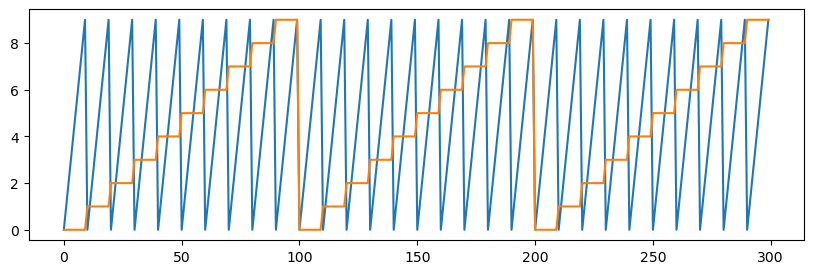

In [32]:
plt.figure(figsize=(10,3))
plt.plot(x,y0)
plt.plot(x,y1)

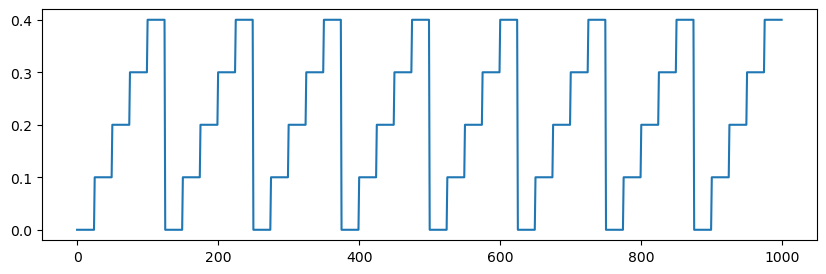

In [60]:
plt.figure(figsize=(10,3))
plt.plot(x,y1)

In [29]:
#np.zeros(shape=(60,4))

In [41]:
pos=10
dim=6
n=10000
for i in range(int(dim/2)):
    print(i)
    denominator = np.power(n, 2*i/dim)
    print(np.sin(pos/denominator))
    print(np.cos(pos/denominator))

0
-0.5440211108893698
-0.8390715290764524
1
0.4476708347189573
0.8941984252625543
2
0.02154268027233166
0.9997679295349917


In [43]:
PE

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 8.41470985e-01,  5.40302306e-01,  7.61720408e-01, ...,
         9.99999991e-01,  1.15478198e-04,  9.99999993e-01],
       [ 9.09297427e-01, -4.16146837e-01,  9.87046251e-01, ...,
         9.99999964e-01,  2.30956395e-04,  9.99999973e-01],
       ...,
       [ 1.23573123e-01, -9.92335469e-01,  1.39920673e-01, ...,
         9.99980359e-01,  5.42744868e-03,  9.99985271e-01],
       [-7.68254661e-01, -6.40144339e-01, -6.63571724e-01, ...,
         9.99979514e-01,  5.54292514e-03,  9.99984638e-01],
       [-9.53752653e-01,  3.00592544e-01, -9.99784705e-01, ...,
         9.99978652e-01,  5.65840153e-03,  9.99983991e-01]])

[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ...  1.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 8.41470985e-01  5.40302306e-01  7.61720408e-01 ...  9.99999991e-01
   1.15478198e-04  9.99999993e-01]
 [ 9.09297427e-01 -4.16146837e-01  9.87046251e-01 ...  9.99999964e-01
   2.30956395e-04  9.99999973e-01]
 ...
 [ 1.23573123e-01 -9.92335469e-01  1.39920673e-01 ...  9.99980359e-01
   5.42744868e-03  9.99985271e-01]
 [-7.68254661e-01 -6.40144339e-01 -6.63571724e-01 ...  9.99979514e-01
   5.54292514e-03  9.99984638e-01]
 [-9.53752653e-01  3.00592544e-01 -9.99784705e-01 ...  9.99978652e-01
   5.65840153e-03  9.99983991e-01]]


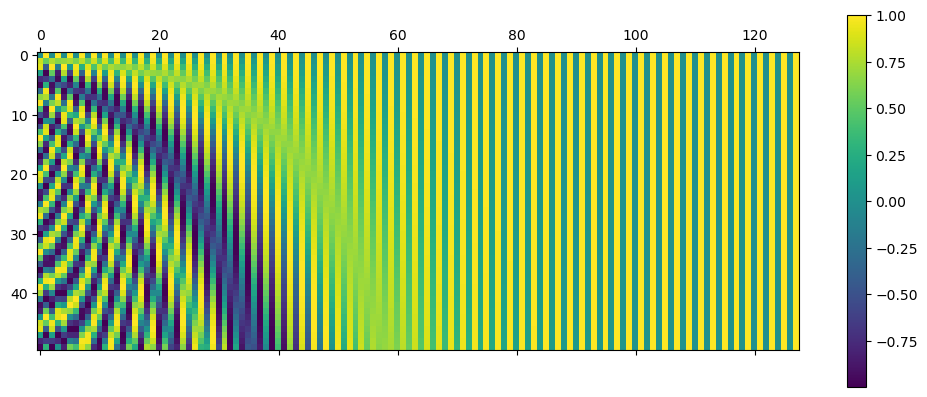

In [42]:
def getPositionEncoding(seq_len,dim,n=10000):
  PE = np.zeros(shape=(seq_len,dim))
  for pos in range(seq_len):
    for i in range(int(dim/2)):
      denominator = np.power(n, 2*i/dim)
      PE[pos,2*i] = np.sin(pos/denominator)
      PE[pos,2*i+1] = np.cos(pos/denominator)

  return PE

PE = getPositionEncoding(seq_len=50, dim=128, n=10000)
print(PE)

caxes = plt.matshow(PE,interpolation ='nearest')
plt.colorbar(caxes) 
plt.show()

## transformer 中的位置编码的使用

https://blog.csdn.net/qq_52785473/article/details/124537101

* register_buffer(self, name, tensor)是一个PyTorch中的方法，它的作用是向模块（module）中添加一个持久的缓冲区（buffer）缓冲区是一种不被视为模型参数（model parameter）的张量（tensor），它不会在训练过程中更新梯度（gradient），但是会作为模块的状态（state）被保存和迁移

### classwork1

* 已知如下类，通过给定的x运行下面的词嵌入类和位置编码类，并打印结果张量及其维度

In [4]:
#词嵌入
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
    # d_model:词嵌入维度
    # vocab:字典大小
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [3]:
d_model = 10  # embedding_size
vocab = 1000  # 词典大小
x=torch.tensor([[100, 2, 421, 508], [491, 998, 1, 221]], dtype=torch.long)
emb = Embeddings(d_model, vocab)
embr = emb(x)
print(embr.shape)

torch.Size([2, 4, 10])


In [4]:
embr

tensor([[[ 1.6527, -4.2898, -7.0676, -0.2879,  0.4503,  1.6593, -2.8290,
           1.3239, -1.3528, -4.3423],
         [-4.9873, -3.2457,  0.4685,  4.4773, -1.5115,  1.9148,  5.6802,
           0.6057, -1.2208,  6.1044],
         [-4.9777, -0.6284,  3.7511, -2.1237, -2.1275, -2.0945,  1.9090,
          -0.8950, -1.1659,  3.0948],
         [ 1.4378, -0.2923,  3.4058, -3.2347, -0.0213, -0.3064,  4.0613,
          -1.1672,  1.3529,  4.8704]],

        [[-2.6389,  2.8365,  0.8154, -0.3518, -6.1504,  1.6444, -5.8082,
          -2.5264,  1.7637,  4.9342],
         [-3.8343, -0.5000,  2.1118, -3.0764, -0.7894, -4.6728,  9.5358,
          -1.1405,  1.7375,  2.8379],
         [-5.8903, -1.5858,  2.1292, -3.7824, -5.0227,  6.0156, -4.5564,
           0.9712, -1.4247,  2.6252],
         [-4.0722, -5.1162, -0.9665, -2.3756,  0.1784,  1.8918,  2.3819,
           2.1925, -3.7461, -0.3825]]], grad_fn=<MulBackward0>)

In [5]:
#位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
    # d_model:词嵌入维度
    # dropout:置零比率
    # max_len:每个句子最大的长度
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0,  max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(1000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)
        #return x

In [86]:
dropout = 0.1
max_len = 60
pe = PositionalEncoding(d_model, dropout, max_len)
pe_result = pe(embr)
print(pe_result.shape)

torch.Size([2, 4, 10])


# 注意力机制的思想与原理

文字，全流程详细讲解，无代码 https://blog.csdn.net/benzhujie1245com/article/details/117173090

视频，原因讲解 https://www.bilibili.com/video/BV1dt4y1J7ov/

视频，讲解详细 https://www.bilibili.com/video/BV1v3411r78R/

文字，简单讲解，有代码 https://blog.csdn.net/qq_52785473/article/details/124537101

文字，简单讲解，有代码 https://blog.csdn.net/Datawhale/article/details/120320116

https://wmathor.com/index.php/archives/1438/

内积的几何意义

https://cloud.tencent.com/developer/article/2157496


https://zhuanlan.zhihu.com/p/631398525

注意力机制（Attention Mechanism）是机器学习，尤其是深度学习领域中的一种技术，它模仿了人类视觉或听觉系统中的注意力选择能力。在处理信息时，人类不会对所有部分给予同等关注，而是有选择地聚焦于某些特定的部分。这种机制允许模型在处理序列数据时，比如翻译任务中的源语言句子到目标语言句子的转换，能够“关注”到输入序列的不同部分。

### 注意力机制的起源

注意力机制的概念最早可以追溯到20世纪90年代的人工神经网络研究，但直到2014年，Bahdanau等人在其论文《Neural Machine Translation by Jointly Learning to Align and Translate》中首次将注意力机制成功应用于神经机器翻译（NMT），才使得这一概念在深度学习领域得到了广泛的关注和发展。这篇论文提出了一种模型，该模型不仅能够学习如何翻译，还能学习如何对齐源语言和目标语言中的词语，即通过一个软对齐的方式确定哪些源语言词对于生成某个目标语言词更重要。

### 注意力机制的基本公式

注意力机制的核心在于计算一个权重分布，这个分布反映了在给定上下文的情况下，各个输入元素的重要性。基本的注意力机制可以分为以下几个步骤：

1. **得分函数（Score Function）**：首先计算查询向量（query vector）与每个键向量（key vector）之间的相似度得分。常用的得分函数包括点积、加性（或称巴赫达努式，Bahdanau-style）、缩放点积等。例如，使用点积作为得分函数：
   $$ e_{ij} = \text{score}(\mathbf{q}_i, \mathbf{k}_j) = \mathbf{q}_i^T\mathbf{k}_j $$
   其中，$\mathbf{q}_i$ 是查询向量，$\mathbf{k}_j$ 是第 $j$ 个键向量。

2. **权重计算（Weight Calculation）**：将得分转化为概率分布，通常使用softmax函数来实现，这样可以确保所有权重的总和为1。
   $$ \alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k=1}^{T}\exp(e_{ik})} $$
   其中，$T$ 是键向量的数量，$\alpha_{ij}$ 表示第 $j$ 个键向量相对于查询向量 $i$ 的注意力权重。

3. **加权求和（Weighted Sum）**：根据计算得到的权重，对值向量（value vector）进行加权求和，生成上下文向量（context vector）。
   $$ \mathbf{c}_i = \sum_{j=1}^{T} \alpha_{ij} \mathbf{v}_j $$
   其中，$\mathbf{v}_j$ 是与键向量 $\mathbf{k}_j$ 相对应的值向量，$\mathbf{c}_i$ 是最终的上下文向量，用于后续的处理或决策。

这些步骤构成了注意力机制的基础框架，但在实际应用中，根据不同的任务需求，可能会有所变化或扩展。例如，在自然语言处理任务中，查询、键和值向量通常是从文本序列中提取的特征表示；而在计算机视觉任务中，则可能是从图像中提取的特征图。

### 线性运算的意义

* 向量点乘向量

点乘的一个重要几何意义是它可以表示一个向量在另一个向量上的投影长度。

* 矩阵点乘自身转置

当一个矩阵与自身的转置进行点乘（内积）运算时，我们实际上是在计算该矩阵的每个行向量与其自身或其它行向量的点积。这种操作通常用于计算矩阵的行向量之间的相似度或者构造协方差矩阵等。

* 矩阵点乘自身的相似性系数矩阵

当你用若干向量构成一个矩阵，并且考虑这些向量之间的相关性系数时，你实际上是在探索这些向量之间的线性关系。

假设你有一个 $ m \times n $ 的矩阵 $ A $，其中每一列代表一个向量，共有 $ n $ 个向量，每个向量有 $ m $ 个元素。为了计算这些向量之间的相关性系数，通常需要对这些向量进行标准化处理，使其均值为 0，标准差为 1。这样做的目的是消除量纲的影响，使得相关性系数能够更好地反映向量之间的线性关系。

* 相关性系数矩阵

1. **标准化**：首先，对矩阵 $ A $ 中的每个向量进行标准化处理，得到标准化后的矩阵 $ Z $。标准化的公式为：
   $$
   z_{ij} = \frac{a_{ij} - \bar{a}_j}{s_j}
   $$
   其中，$ \bar{a}_j $ 是第 $ j $ 列的均值，$ s_j $ 是第 $ j $ 列的标准差。

2. **计算相关性系数矩阵**：接下来，计算标准化后的矩阵 $ Z $ 的转置 $ Z^T $ 与 $ Z $ 的乘积，然后除以 $ m-1 $（样本数量减一），得到相关性系数矩阵 $ R $：
   $$
   R = \frac{1}{m-1} Z^T Z
   $$
   其中，$ R $ 是一个 $ n \times n $ 的矩阵，其元素 $ r_{ij} $ 表示第 $ i $ 列向量和第 $ j $ 列向量之间的相关性系数。

3. 相关性系数点乘的意义

 **与向量点乘**：如果你有一个向量 $ v $（假设维度为 $ n $），你可以计算 $ Rv $ 或 $ v^TR $。这可以理解为将向量 $ v $ 在相关性系数矩阵 $ R $ 所定义的空间中进行变换。例如，$ Rv $ 的结果向量中的每个元素表示 $ v $ 与 $ A $ 中每个向量的相关性加权和。

 **与矩阵点乘**：如果你有一个矩阵 $ B $（假设维度为 $ n \times p $），你可以计算 $ RB $ 或 $ BR $。这可以理解为将矩阵 $ B $ 中的每个向量在相关性系数矩阵 $ R $ 所定义的空间中进行变换。例如，$ RB $ 的结果矩阵中的每个列向量表示 $ B $ 中对应列向量与 $ A $ 中每个向量的相关性加权和。

4. 应用场景

 **特征选择**：在机器学习中，相关性系数可以用于特征选择，帮助识别哪些特征之间存在高度相关性，从而避免模型中的多重共线性问题。

 **数据降维**：在主成分分析（PCA）中，相关性系数矩阵用于计算协方差矩阵，进而提取数据的主要成分。
 
 **聚类分析**：在聚类分析中，相关性系数可以用于度量不同样本之间的相似性，帮助构建聚类模型。

总之，相关性系数矩阵及其点乘操作在数据分析和机器学习中有着广泛的应用，能够帮助我们更好地理解和处理多维数据。 

In [11]:
from IPython.display import Image
Image(url= "https://pic1.zhimg.com/v2-43d8ebce2c5a2cb511331014a05aa688_1440w.jpg")

In [1]:
from IPython.display import Image
Image(url= "33.png")

In [7]:
Image(url= "34.png")

自注意力（Self-Attention）机制是注意力机制的一种特殊形式，它允许模型在同一序列内进行信息交互，而不需要依赖于外部的上下文信息。自注意力机制在处理长距离依赖关系时表现尤为出色，因此在自然语言处理（NLP）领域得到了广泛应用，尤其是在Transformer模型中。最早的自注意力机制是由Vaswani等人在2017年的论文《Attention is All You Need》中提出的。

### 自注意力的思想

自注意力的核心思想是，让序列中的每个位置都能够关注到序列中的其他位置，从而捕获更丰富的上下文信息。这种机制使得模型能够在处理长序列时，有效地捕捉远距离的依赖关系，而不需要像传统的RNN或LSTM那样逐个处理序列元素。

### 自注意力的工作原理

自注意力机制的基本步骤如下：

1. **输入表示**：假设我们有一个输入序列 $X = [x_1, x_2, \ldots, x_n]$，其中每个 $x_i$ 是一个向量。

2. **线性变换**：对输入序列中的每个向量进行线性变换，生成查询向量（Query）、键向量（Key）和值向量（Value）。这些变换通常通过矩阵乘法实现：
   $$ Q = XW^Q, \quad K = XW^K, \quad V = XW^V $$
   其中，$W^Q$, $W^K$, 和 $W^V$ 是可学习的权重矩阵。

3. **计算注意力分数**：使用查询向量和键向量计算注意力分数。最常见的方法是缩放点积注意力（Scaled Dot-Product Attention）：
   $$ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$
   其中，$d_k$ 是键向量的维度，用于缩放点积以防止梯度消失或爆炸。

4. **加权求和**：将注意力分数与值向量相乘，并进行加权求和，得到最终的输出向量：
   $$ \text{Output} = \text{Attention}(Q, K, V) $$

### 详细公式

假设输入序列 $X$ 的形状为 $(n, d)$，其中 $n$ 是序列长度，$d$ 是向量维度。经过线性变换后，查询向量 $Q$、键向量 $K$ 和值向量 $V$ 的形状均为 $(n, d_k)$。

1. **线性变换**：
   $$ Q = XW^Q, \quad K = XW^K, \quad V = XW^V $$
   其中，$W^Q$, $W^K$, 和 $W^V$ 的形状分别为 $(d, d_k)$。

2. **计算注意力分数**：
   $$ \text{Scores} = QK^T / \sqrt{d_k} $$
   这里的 $\text{Scores}$ 形状为 $(n, n)$，表示每个位置对其他位置的注意力分数。

3. **应用softmax**：
   $$ \text{Attention Weights} = \text{softmax}(\text{Scores}) $$
   这里的 $\text{Attention Weights}$ 形状也为 $(n, n)$，表示每个位置对其他位置的注意力权重。

4. **加权求和**：
   $$ \text{Output} = \text{Attention Weights} \cdot V $$
   这里的 $\text{Output}$ 形状为 $(n, d_k)$，表示每个位置的输出向量。

### 优点

- **并行计算**：自注意力机制可以在并行计算中高效运行，因为每个位置的计算是独立的。
- **长距离依赖**：自注意力机制能够有效捕捉长距离依赖关系，而不需要像RNN或LSTM那样逐个处理序列元素。
- **灵活的上下文建模**：每个位置可以关注到序列中的任意其他位置，从而捕获更丰富的上下文信息。

### 应用

自注意力机制在许多NLP任务中表现出色，包括但不限于机器翻译、文本分类、情感分析、命名实体识别等。特别是在Transformer模型中，自注意力机制是其核心组成部分，使得Transformer在各种NLP基准测试中取得了显著的成绩。

In [8]:
Image(url= "self0.png")

https://blog.csdn.net/benzhujie1245com/article/details/117173090

In [56]:
input_size=40
hidden_size=20
query = nn.Linear(input_size, hidden_size)
key = nn.Linear(input_size, hidden_size)
value = nn.Linear(input_size, hidden_size)

In [62]:
x = torch.randn(30, 40)
q = query(x)
k = key(x)
v = value(x)
#x

In [66]:
out=torch.mm(q, k.transpose(0, 1))/math.sqrt(20)
out=torch.softmax(out, dim=-1)
out=torch.mm(out, v)
out

tensor([[-0.2679, -0.2205,  0.2756,  0.1129, -0.1622,  0.1292,  0.0112,  0.0633,
          0.2567,  0.1563,  0.0401,  0.0610,  0.1346,  0.1730, -0.1554,  0.1603,
          0.0114, -0.2817, -0.0760,  0.1398],
        [-0.3397, -0.2865,  0.2437,  0.1693, -0.0989,  0.1774,  0.0426,  0.0056,
          0.2165,  0.0444,  0.0655,  0.0495,  0.1462,  0.0825, -0.1607,  0.1153,
          0.0105, -0.1826, -0.1456,  0.0346],
        [-0.1287, -0.2080,  0.2769,  0.1123, -0.1086,  0.0015,  0.0135,  0.0934,
          0.2634,  0.1655, -0.0381,  0.1561,  0.1477,  0.2539, -0.1699,  0.1506,
          0.0036, -0.2497, -0.0871,  0.1638],
        [-0.1649, -0.2830,  0.2431,  0.1282, -0.0949,  0.1305,  0.0420,  0.0427,
          0.2329, -0.0145, -0.0466,  0.0741,  0.0861,  0.1564, -0.1680,  0.1151,
          0.0456, -0.1558, -0.1820,  0.0415],
        [-0.2099, -0.2515,  0.2563,  0.0168, -0.1187,  0.0099, -0.0300,  0.1171,
          0.2640,  0.0848, -0.0839,  0.0782,  0.1152,  0.2258, -0.1635,  0.1898,
      

In [26]:
x = torch.randn(20, 40)
q = query(x)
k = key(x)
v = value(x)

In [33]:
attn_weights = torch.mm(q, k.transpose(0, 1))
attn_weights = F.softmax(attn_weights, dim=-1)
attn_output = torch.mm(attn_weights, v)

In [13]:
class SelfAttention(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_size, hidden_size)
        self.key = nn.Linear(input_size, hidden_size)
        self.value = nn.Linear(input_size, hidden_size)

    def forward(self, x):
        # 计算Q、K、V
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        # 计算自注意力矩阵
        attn_weights = torch.mm(q, k.transpose(0, 1))
        attn_weights = F.softmax(attn_weights, dim=-1)
        # 使用自注意力矩阵对V进行加权平均
        attn_output = torch.mm(attn_weights, v)
        return attn_output

In [15]:
input_size=40
hidden_size=20
model = SelfAttention(input_size, hidden_size)
x = torch.randn(30, 40)
out = model(x)
out.shape

torch.Size([30, 20])

## 多头自注意力机制

https://blog.csdn.net/benzhujie1245com/article/details/117173090

多头注意力（Multi-Head Attention）机制是注意力机制的一个重要变体，它通过并行使用多个注意力头（attention heads）来捕捉输入序列中的不同信息。这种机制允许模型在不同的表示子空间中同时关注输入的不同方面，从而提高了模型的表达能力和灵活性。多头注意力最著名的应用是在Transformer模型中，该模型由Vaswani等人在2017年的论文《Attention is All You Need》中提出。

### 多头注意力的思想

多头注意力的基本思想是，通过将输入向量映射到多个不同的低维空间（即多个“头”），每个头可以专注于输入的不同方面或特征。然后，将这些头的输出组合起来，形成更丰富的表示。这种方式类似于人脑在处理信息时，能够同时关注多个特征的能力。

### 多头注意力的工作原理

1. **线性变换**：首先，输入向量通过线性变换映射到多个低维空间。具体来说，对于每个头，都有独立的权重矩阵 $W^Q_i$, $W^K_i$, 和 $W^V_i$ 分别用于查询（Query）、键（Key）和值（Value）的线性变换。假设我们有 $h$ 个头，那么对于每个头 $i$，我们可以得到：
   $$ \mathbf{Q}_i = X W^Q_i, \quad \mathbf{K}_i = X W^K_i, \quad \mathbf{V}_i = X W^V_i $$
   其中，$X$ 是输入向量矩阵，$W^Q_i$, $W^K_i$, 和 $W^V_i$ 是第 $i$ 个头的权重矩阵。

2. **计算注意力分数**：对于每个头，使用标准的注意力机制计算注意力分数。通常使用缩放点积注意力（Scaled Dot-Product Attention）：
   $$ \text{Attention}(\mathbf{Q}_i, \mathbf{K}_i, \mathbf{V}_i) = \text{softmax}\left(\frac{\mathbf{Q}_i \mathbf{K}_i^T}{\sqrt{d_k}}\right) \mathbf{V}_i $$
   其中，$d_k$ 是键向量的维度，用于缩放点积以防止梯度消失或爆炸。

3. **拼接头的输出**：将所有头的输出拼接在一起，形成一个更大的向量：
   $$ \text{Concat}(\text{head}_1, \text{head}_2, \ldots, \text{head}_h) $$
   其中，$\text{head}_i = \text{Attention}(\mathbf{Q}_i, \mathbf{K}_i, \mathbf{V}_i)$。

4. **最终线性变换**：为了将拼接后的向量映射回原始维度，通常会再进行一次线性变换：
   $$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \text{head}_2, \ldots, \text{head}_h) W^O $$
   其中，$W^O$ 是最终的线性变换矩阵。

### 优点

- **捕捉多种信息**：多头注意力机制可以通过不同的头捕捉输入序列中的不同信息，从而提高模型的表达能力。
- **并行计算**：由于每个头的计算是独立的，可以并行执行，提高了计算效率。
- **灵活性**：每个头可以学习不同的表示子空间，使得模型能够更好地适应复杂的任务。

### 应用

多头注意力机制在许多自然语言处理任务中取得了显著的效果，包括但不限于机器翻译、文本分类、情感分析等。它也是Transformer模型的核心组成部分，该模型在各种NLP基准测试中表现出色。

In [16]:
Image(url= "https://i-blog.csdnimg.cn/blog_migrate/d4af5c34f2e6bc4436e739e112767fc6.png")

In [17]:
Image(url= "https://i-blog.csdnimg.cn/blog_migrate/812411cda1aa0f9206469428b743e1c2.png")

In [29]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    print("scores",scores.size())
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)

    if dropout is not None:
        p_attn = dropout(p_attn)
    
    return torch.matmul(p_attn, value), p_attn

# 深层拷贝
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class MultiHeadedAttention(nn.Module):
    def __init__(self, head, embedding_dim, dropout=0.1):
        # head:代表几个头
        # embedding_dim:词嵌入维度
        # dropout:置0比率
        super(MultiHeadedAttention, self).__init__()

        # 确认embedding_dim能够被head整除
        assert embedding_dim % head == 0
        self.head = head
        self.d_k = embedding_dim // head
        # 获得4个线性层， 分别是Q、K、V、以及最终的输出的线形层
        self.linears = clones(nn.Linear(embedding_dim, embedding_dim), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(0)
        
        batch_size = query.size(0)
        print(query.size())

        # 经过线性层投影后分成head个注意力头
        query, key, value = [model(x).view(batch_size, -1, self.head, self.d_k).transpose(1, 2) for model, x in zip(self.linears, (query, key, value))]
        # 各自计算每个头的注意力
        print("query-hou",query.size())
        
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 转换回来
        print("x-qian",x.size())
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.head * self.d_k)
        print("x-hou",x.size())
        # 经过最后一个线性层得到最终多头注意力机制的结果
        return self.linears[-1](x)

In [ ]:
model(x)

In [22]:
list(zip([1,2,3,4],[6,7,8]))

[(1, 6), (2, 7), (3, 8)]

In [16]:
d_model = 512  # embedding_size
vocab = 1000  # 词典大小
x=torch.tensor([[100, 2, 421, 508], [491, 998, 1, 221]], dtype=torch.long)
emb = Embeddings(d_model, vocab)
embr = emb(x)
print(embr.shape)

torch.Size([2, 4, 512])


In [17]:
dropout = 0.1
max_len = 60
pe = PositionalEncoding(d_model, dropout, max_len)
pe_result = pe(embr)
print(pe_result.shape)

torch.Size([2, 4, 512])


In [19]:
8*64

512

In [30]:
head = 8
embedding_dim = 512
query = key = value = pe_result
mask = torch.zeros(8, 4, 4)
mha = MultiHeadedAttention(head, embedding_dim, dropout)
mha_result = mha(query, key, value, mask)
print(mha_result)
print(mha_result.shape)

torch.Size([2, 4, 512])
query-hou torch.Size([2, 8, 4, 64])
scores torch.Size([2, 8, 4, 4])
x-qian torch.Size([2, 8, 4, 64])
x-hou torch.Size([2, 4, 512])
tensor([[[ -3.1943,  -4.0948,   0.9919,  ...,   2.6264,   1.8804,  -1.6028],
         [ -6.3764,  -4.1197,  -1.5219,  ...,  -1.4719,   6.4804,  -6.0069],
         [ -4.0881,  -1.4219,   0.8747,  ...,   1.0582,   4.8356,  -2.7968],
         [ -6.1818,  -2.3725,  -0.0891,  ...,   1.6376,   7.5973,  -2.0800]],

        [[ -3.9450,  -9.1723,   2.0190,  ...,  -3.5826,  -6.9150,   0.4424],
         [ -4.6037, -12.1414,   1.7822,  ...,  -2.4616,  -7.8320,   3.9605],
         [ -2.9337, -10.4589,   2.3938,  ...,  -1.3707,  -6.5807,   3.7163],
         [ -4.7333, -11.4768,   1.1390,  ...,  -1.2973,  -5.3891,   3.7132]]],
       grad_fn=<ViewBackward0>)
torch.Size([2, 4, 512])


In [22]:
query = key = value = pe_result
mask = Variable(torch.zeros(2, 4, 4))
attn, p_attn = attention(query, key, value,mask=mask)
# print(attn)
# print(attn.shape)
# print(p_attn)
# print(p_attn.shape)